Total positive reviews: 86259
Total negative reviews: 13551


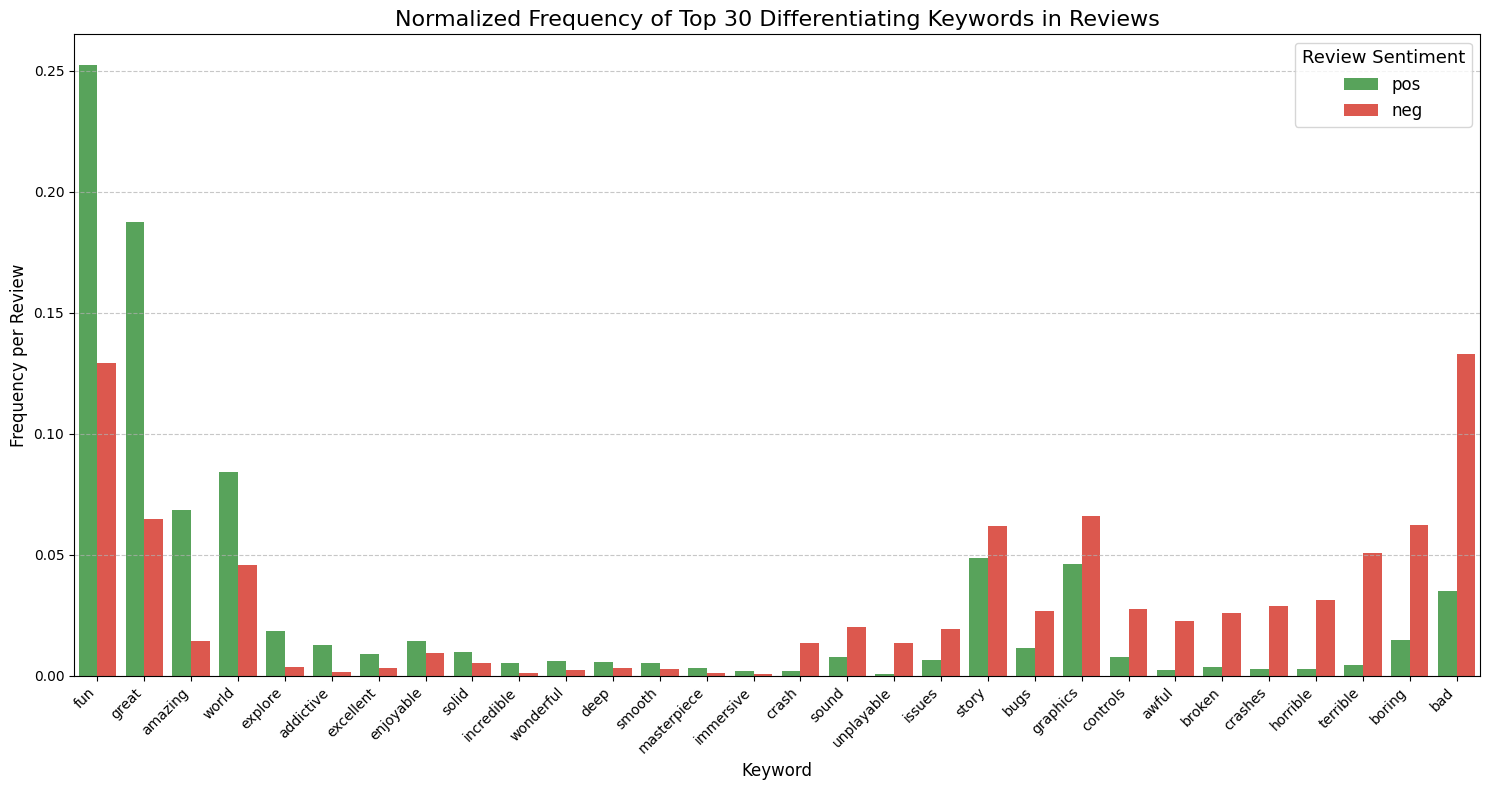


Top words more frequent in positive reviews:
           word  freq_pos  freq_neg  frequency_difference
33          fun  0.252333  0.129216              0.123118
37        great  0.187354  0.064866              0.122488
1       amazing  0.068665  0.014316              0.054349
74        world  0.084188  0.045753              0.038435
28      explore  0.018665  0.003764              0.014901
0     addictive  0.012660  0.001550              0.011110
27    excellent  0.009019  0.003099              0.005920
24    enjoyable  0.014236  0.009520              0.004717
59        solid  0.009645  0.005166              0.004480
41   incredible  0.005414  0.001181              0.004233
73    wonderful  0.005924  0.002509              0.003415
17         deep  0.005878  0.003026              0.002852
58       smooth  0.005228  0.002804              0.002424
47  masterpiece  0.003339  0.001181              0.002158
39    immersive  0.002156  0.000812              0.001345

Top words more frequent i

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. Load Hadoop results ---
# Loads the results from the Hadoop job (output_h1.txt).
# Assumes the file is located at 'Project/output_h1.txt' and uses a tab as a separator.
df_hadoop = pd.read_csv(
    "Project/output_h1.txt", sep="\t", header=None, names=["key", "count"]
)

# Splits the 'key' column (e.g., "pos_gameplay") into 'label' ("pos" or "neg") and 'word' ("gameplay").
df_hadoop[["label", "word"]] = df_hadoop["key"].str.split("_", expand=True)

# --- 2. Load the original dataset to count total reviews by sentiment ---
# The total number of positive and negative reviews is needed to normalize frequencies.
# Assumes the 'clean_sample.csv' file is located at 'Project/clean_sample.csv'.
df_reviews = pd.read_csv("Project/clean_sample.csv")

# Counts the total number of reviews with a score of 1 (positive) and -1 (negative).
n_pos = (df_reviews["review_score"] == 1).sum()
n_neg = (df_reviews["review_score"] == -1).sum()
total_reviews = {"pos": n_pos, "neg": n_neg}

# Prints the total count of positive and negative reviews.
print(f"Total positive reviews: {n_pos}")
print(f"Total negative reviews: {n_neg}")

# --- 3. Calculate normalized frequency ---
# Normalized frequency is the count of a word divided by the total number of reviews
# for that sentiment type. This gives the 'frequency per review'.
df_hadoop["normalized_frequency"] = df_hadoop.apply(
    lambda row: (
        row["count"] / total_reviews[row["label"]]
        if total_reviews[row["label"]] > 0
        else 0
    ),
    axis=1,
)

# --- 4. Prepare data for difference analysis ---
# Pivots the DataFrame to have normalized frequencies for 'pos' and 'neg' for each word
# in separate columns.
pivot_df = df_hadoop.pivot_table(
    index="word", columns="label", values="normalized_frequency", fill_value=0
).reset_index()

# Renames the pivoted columns for clarity.
pivot_df.columns.name = None  # Removes the column axis name.
pivot_df = pivot_df.rename(columns={"pos": "freq_pos", "neg": "freq_neg"})

# Calculates the difference in frequency to identify distinctive keywords.
# A high positive value means the word is more frequent in positive reviews.
# A high negative value (in magnitude) means the word is more frequent in negative reviews.
pivot_df["frequency_difference"] = pivot_df["freq_pos"] - pivot_df["freq_neg"]

# --- 5. Select the N most relevant keywords ---
N_TOP_WORDS = 15  # Adjust this number to display more or fewer words.

# Sorts the words by frequency difference:
# Most positive words will be at the top, most negative words at the bottom.
sorted_words_by_diff = pivot_df.sort_values(by="frequency_difference", ascending=False)

# Selects the N words most associated with positive reviews.
top_pos_words = sorted_words_by_diff.head(N_TOP_WORDS)
# Selects the N words most associated with negative reviews.
top_neg_words = sorted_words_by_diff.tail(N_TOP_WORDS).sort_values(
    by="frequency_difference", ascending=False
)

# Combines the lists of words for visualization.
# This ensures that the most distinctive words from both ends of the spectrum are shown.
words_to_plot = pd.concat([top_pos_words, top_neg_words])["word"].unique()


# Filters the original Hadoop DataFrame to include only the selected words.
plot_df = df_hadoop[df_hadoop["word"].isin(words_to_plot)].copy()

# Orders the words on the plot so that the most positive and most negative appear in order.
# This is crucial for a clear visualization of the hypothesis.
# A CategoricalDtype is used to control the order of the X-axis in the plot.
ordered_words = sorted_words_by_diff[sorted_words_by_diff["word"].isin(words_to_plot)][
    "word"
].tolist()
plot_df["word"] = pd.Categorical(
    plot_df["word"], categories=ordered_words, ordered=True
)

# Ensures that the order of 'pos' and 'neg' labels is consistent in the legend/bars.
plot_df["label"] = pd.Categorical(
    plot_df["label"], categories=["pos", "neg"], ordered=True
)


# --- 6. Generate the plot ---
plt.figure(figsize=(15, 8))  # Increases figure size for better readability.

sns.barplot(
    data=plot_df.sort_values(
        by=["word", "label"]
    ),  # Sorts data for consistent plotting.
    x="word",
    y="normalized_frequency",
    hue="label",
    palette={
        "pos": "#4CAF50",  # Distinctive color for positive sentiment.
        "neg": "#F44336",  # Distinctive color for negative sentiment.
    },
)

plt.title(
    f"Normalized Frequency of Top {N_TOP_WORDS*2} Differentiating Keywords in Reviews",
    fontsize=16,
)
plt.ylabel("Frequency per Review", fontsize=12)
plt.xlabel("Keyword", fontsize=12)
plt.xticks(
    rotation=45, ha="right", fontsize=10
)  # Rotates X-axis labels to prevent overlap.
plt.yticks(fontsize=10)
plt.legend(title="Review Sentiment", title_fontsize="13", fontsize="12")
plt.tight_layout()  # Adjusts layout to prevent elements from overlapping.
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Adds a subtle Y-axis grid.
plt.show()

# --- Optional: Display the most distinctive words in a table ---
print("\nTop words more frequent in positive reviews:")
print(
    top_pos_words[["word", "freq_pos", "freq_neg", "frequency_difference"]].head(
        N_TOP_WORDS
    )
)

print("\nTop words more frequent in negative reviews:")
print(
    top_neg_words[["word", "freq_pos", "freq_neg", "frequency_difference"]].tail(
        N_TOP_WORDS
    )
)